Join the data from Part 1 with the data from Part 2 to create a new dataframe.

In [ ]:
import os
import requests
import pandas as pd
from math import radians, sin, cos, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0
    
    # Conversion degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    # Differences in coordinates
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    # Conversion from km to m
    distance = R * c * 1000  
    return distance


url = "http://api.citybik.es/v2/networks/velib"
response = requests.get(url)

if response.status_code == 200:
    data = response.json()
    stations = data['network']['stations']
    
    station_details = []
    for station in stations:
        lat = station['latitude']
        lon = station['longitude']
        free_bikes = station['free_bikes']
        
        station_details.append({
            'latitude': lat,
            'longitude': lon,
            'free_bikes': free_bikes
        })
    
    df_bikes = pd.DataFrame(station_details)
else:
    print(f"Error: {response.status_code}")

yelp_api_key = os.getenv('YELP_API_KEY')
lat, lon = 48.879359419425, 2.3665961623192
yelp_url = f"https://api.yelp.com/v3/businesses/search?latitude={lat}&longitude={lon}&radius=1000"

headers = {
    'Authorization': f'Bearer {yelp_api_key}',
    'Accept': 'application/json'
}

response = requests.get(yelp_url, headers=headers)

if response.status_code == 200:
    data = response.json()

    places_list = []
    if 'businesses' in data:
        for place in data['businesses']:
            name = place.get('name', 'No name')
            location = place.get('location', {})
            address = ", ".join([str(location.get('address1', 'No address provided')),
                                 str(location.get('address2', '')),
                                 str(location.get('address3', ''))]).strip(', ')
            city = location.get('city', 'No city provided')
            country = location.get('country', 'No country provided')
            rating = place.get('rating', 'No rating available')
            coordinates = place.get('coordinates', {})
            lat = coordinates.get('latitude')
            lon = coordinates.get('longitude')
            
            if lat is not None and lon is not None:
                places_list.append({
                    'Name': name,
                    'Address': address,
                    'City': city,
                    'Country': country,
                    'Rating': rating,
                    'latitude': lat,
                    'longitude': lon
                })
            else:
                print(f"Missing latitude/longitude for place: {name}")
    
    df_places = pd.DataFrame(places_list)
else:
    print(f"Error: {response.status_code}")


# Drop rows with missing latitude or longitude
df_bikes.dropna(subset=['latitude', 'longitude'], inplace=True)
df_places.dropna(subset=['latitude', 'longitude'], inplace=True)

# Maximum distance threshold = 100 meters
max_distance = 100  

merged_data = []

for bike_index in range(len(df_bikes)):
    bike_lat = df_bikes.iloc[bike_index]['latitude']
    bike_lon = df_bikes.iloc[bike_index]['longitude']
    free_bikes = df_bikes.iloc[bike_index]['free_bikes']
    
    for place_index in range(len(df_places)):
        place_lat = df_places.iloc[place_index]['latitude']
        place_lon = df_places.iloc[place_index]['longitude']
        
        #Distance between the bike station and the place
        distance = haversine(bike_lat, bike_lon, place_lat, place_lon)
        
        # Check for distance is <= 100m 
        if distance <= max_distance:
            merged_data.append({
                'latitude': bike_lat,
                'longitude': bike_lon,
                'free_bikes': free_bikes,
                'Name': df_places.iloc[place_index]['Name'],
                'Address': df_places.iloc[place_index]['Address'],
                'City': df_places.iloc[place_index]['City'],
                'Country': df_places.iloc[place_index]['Country'],
                'Rating': df_places.iloc[place_index]['Rating'],
                'Distance (m)': distance
            })

# Convert the merged data into a DataFrame
df_merged = pd.DataFrame(merged_data)

# Show the merged DataFrame
print("\nMerged DataFrame:")
print(df_merged)


Merged DataFrame:
     latitude  longitude  free_bikes                       Name  \
0   48.870702   2.358740        13.0                Holybelly 5   
1   48.882030   2.363562        28.0                   La Bulle   
2   48.881270   2.368186         8.0             Point Ephémère   
3   48.871624   2.363927        11.0       Du Pain et des Idées   
4   48.877485   2.366007         7.0                   Le Valmy   
5   48.877485   2.366007         7.0  Street Bangkok Local Food   
6   48.877568   2.369879         2.0            Generator Paris   
7   48.857059   2.341798         6.0  Le Réfectoire - Foodtruck   
8   48.879359   2.366596         0.0                      FLESH   
9   48.879359   2.366596         0.0                  Bizz' Art   
10  48.879359   2.366596         0.0               Kheak & Vero   
11  48.879359   2.366596         0.0           Le Cafe Bizz'art   

                               Address      City Country  Rating  Distance (m)  
0         5 rue Lucien Sampa

Provide a visualization that you used as part of your EDA process. Explain the initial pattern or relationship you discoved through this visualization. 

The pattern observed is that bike stations near popular places (with higher ratings or proximity to popular areas) tend to have fewer free bikes, suggesting higher demand. Stations in less crowded areas seem to have more bikes available. 

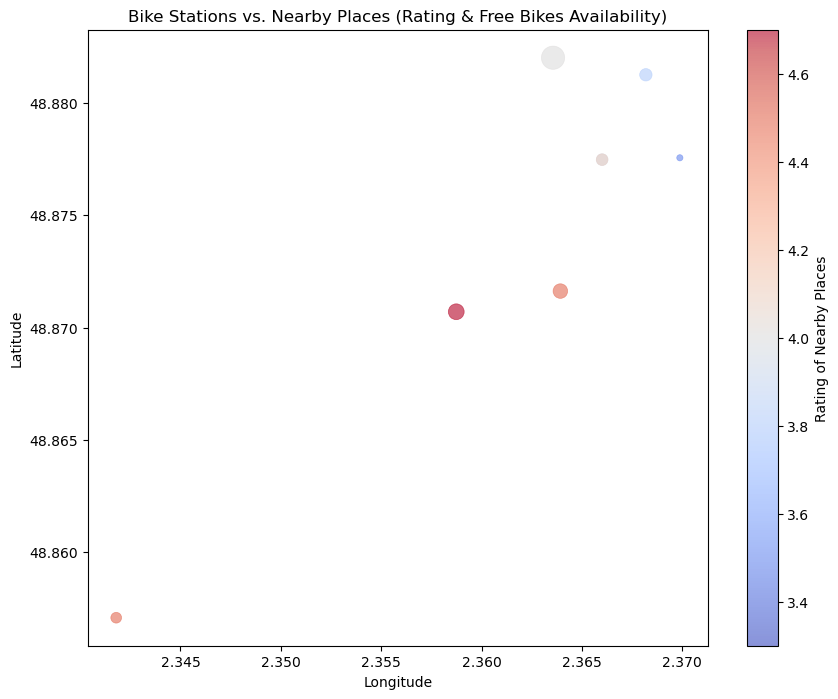

In [27]:
import matplotlib.pyplot as plt

bike_lats = df_merged['latitude'].values
bike_lons = df_merged['longitude'].values
free_bikes = df_merged['free_bikes'].values
ratings = df_merged['Rating'].values
distances = df_merged['Distance (m)'].values

plt.figure(figsize=(10, 8))

scatter = plt.scatter(
    bike_lons, 
    bike_lats, 
    c=ratings,          
    s=free_bikes * 10,  
    alpha=0.6,          # Transparency of the points
    cmap='coolwarm',    # higher ratings are red, lower ratings are blue
    linewidth=0.5,      # Thin border
)


cbar = plt.colorbar(scatter)
cbar.set_label('Rating of Nearby Places')


plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Bike Stations vs. Nearby Places (Rating & Free Bikes Availability)')

plt.show()

# Database

Put all your results in an SQLite3 database (remember, SQLite stores its databases as files in your local machine - make sure to create your database in your project's data/ directory!)

In [ ]:
import sqlite3

db_path = 'data/bike_station_data.db'
conn = sqlite3.connect(db_path)

# Insert the merged DataFrame into the SQLite database
df_merged.to_sql('bike_stations', conn, if_exists='replace', index=False)

conn.close()
print(f"Success!")


Data has been successfully saved to data/bike_station_data.db


Look at the data before and after the join to validate your data.

In [ ]:
import pandas as pd

print("Bike Stations Data")
print(df_bikes.head()) 

print("\nPlaces Data")
print(df_places.head()) 

print("\nMerged Data")
print(df_merged.head())  

print('\n')

# Compare rows before and after merging
print(f"Number of rows in Bike Stations Data: {len(df_bikes)}")
print(f"Number of rows in Places Data: {len(df_places)}")
print(f"Number of rows in Merged Data: {len(df_merged)}")

#Sort by rating
popular_places = df_merged[df_merged['Rating'] >= 4.0]
print("\nStations close to popular places (rating >= 4.0):")
print(popular_places.head())


Bike Stations Data (Before the Join):
    latitude  longitude  free_bikes
0  48.888559   2.264200           7
1  48.836591   2.293056          16
2  48.864186   2.378317          13
3  48.871257   2.486581          19
4  48.831633   2.329312           8

Places Data (Before the Join):
                         Name                        Address   City Country  \
0                    Le Valmy  145 quai de Valmy, None, None  Paris      FR   
1  Restaurant le Robinet d'Or            7 rue Eugène Varlin  Paris      FR   
2                       FLESH     23 rue Louis Blanc, , None  Paris      FR   
3   Street Bangkok Local Food            3 rue Eugène Varlin  Paris      FR   
4      Paname Brewing Company        41 bis quai de la Loire  Paris      FR   

   Rating   latitude  longitude  
0     3.9  48.877615   2.365153  
1     4.1  48.878147   2.364746  
2     4.6  48.880090   2.366840  
3     4.1  48.877830   2.365140  
4     4.2  48.887828   2.378784  

Merged Data (After the Join):
    